<a href="https://colab.research.google.com/github/esis-a-i/Deep-Learning/blob/main/Seminars/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

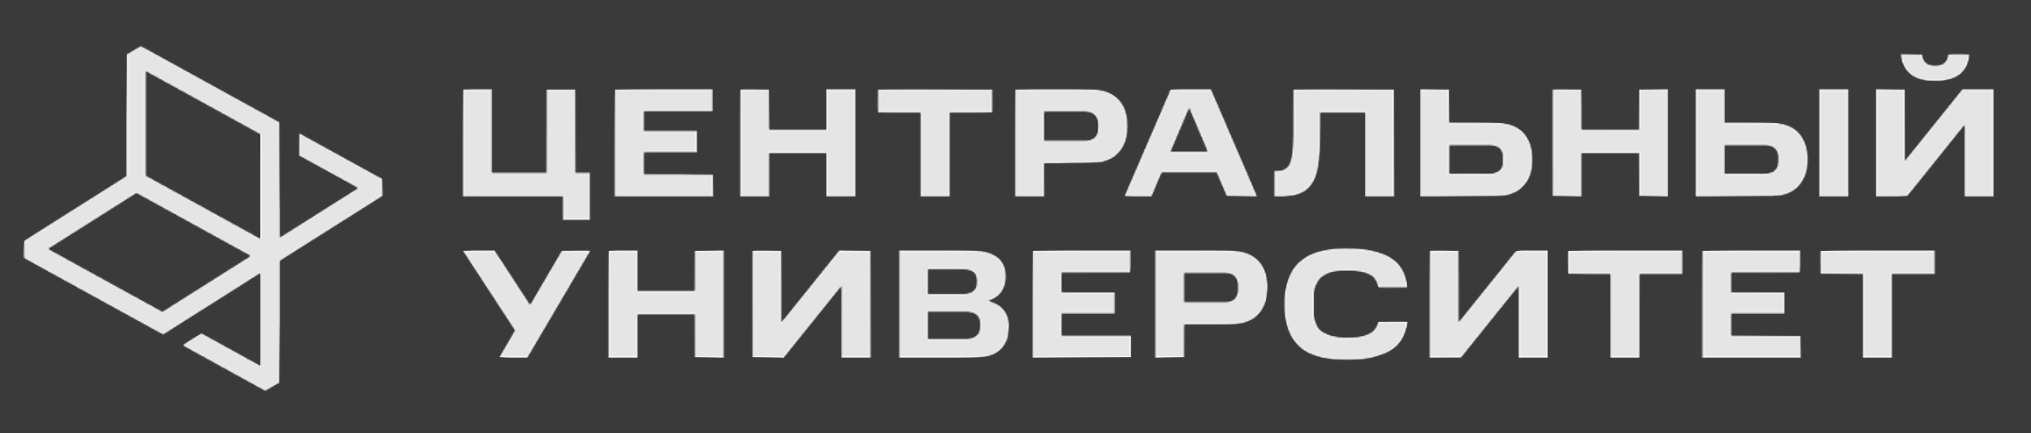

# Transfer Learning

Cделано по

* https://github.com/joe-papa/pytorch-book/blob/main/04_01_Transfer_Learning.ipynb
* (исходник - СМ) https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
https://www.learnpytorch.io/06_pytorch_transfer_learning/

В этом ноутбуке демонстрация  - как можно сделать трансферное обучение

<font color='OrangeRed'>**Обратите внимание!**</font> Тут очень желательно использовать GPU

## 1.Введение

__Проблема__:
Для обучения nn "c нуля" нужно достаточно много размеченных данных (не всегда), много compute.

__Решение__:
Использование transfer learning.
Можно использовать веса моделей, обученной на большом датасете (например, на [ImageNet](https://www.image-net.org/)). Сеть можно дообучать полностью или частично.  

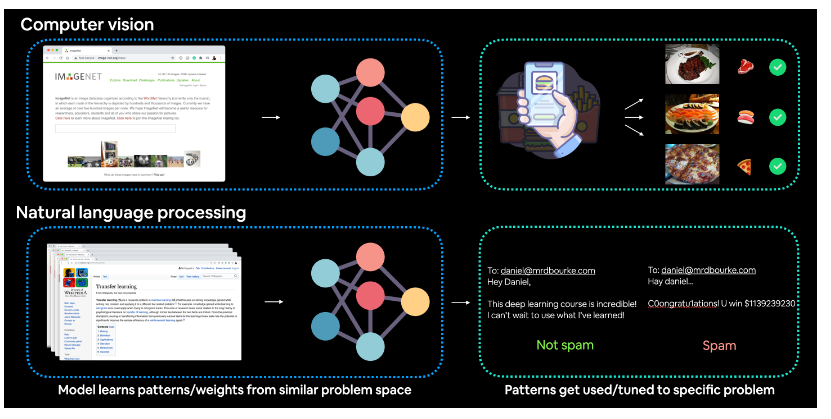

#### Возможный пайплайн для __transfer learning__ (на примере задачи классификации):
1. Берем обученную модель на большом объеме данных (например, на ImageNet).
2. Оставляем все слои модели, кроме выходного слоя (например, это `Linear` слой для задачи классификации).
3. Добавляем новый выходной слой в предобученную модель.Количество выходов которого равно количество классов в новом наборе данных.
4. Дообучаем модель на новом наборе данных.
Выходной слой будет обучен с нуля.
Остальные параметры могут донастраиваться (обучаться как правило с маленьким lr), могут оставляться прежними.

## 2.Примеры репо с обученными моделями

## 2.1 Torchvision

`PyTorch` имеет несколько сопутствующих библиотек, одна из которых — [torchvision](https://github.com/pytorch/vision/tree/main).
Она содержит ряд популярных наборов данных для cv, инструменты предварительной обработки и, что самое важное, предварительно обученные модели.

Вот [тут](https://pytorch.org/vision/main/models.html) можно увидеть весь зоопарк моделей.

In [1]:
import requests
from tqdm import tqdm

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import datasets, models, transforms

torch.manual_seed(42)

from skimage.transform import resize
import matplotlib.pyplot as plt


# Using pretrained weights:
resnet50(weights="IMAGENET1K_V1")
# Initialize model
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

# Set model to eval mode
model.eval()

# Using no weights:
resnet = resnet50(weights=None)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 107MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 97.6MB/s]


#### Напишем простенькую функцию для формирования предсказаний обученной модели

In [2]:
# class labels
LABELS_URL = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
labels = {i: c for i, c in enumerate(requests.get(LABELS_URL).json())}


def transform_input(img):
    return torch.as_tensor(
                          img.reshape([1, 256, 256, 3]).\
                          transpose([0, 3, 1, 2]), dtype=torch.float32
                          )


def predict(model, img):
    img = transform_input(img)
    probs = torch.nn.functional.softmax(model(img), dim=-1)
    probs = probs.data.numpy()

    top_ix = probs.ravel().argsort()[-1:-10:-1]
    print ('top-10 classes are: \n [prob : class label]')
    for l in top_ix:
        print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))

In [4]:
!wget https://cdn.akamai.steamstatic.com/steamcommunity/public/images/clans/30297037/46db5ab0b1643199f65eef34933fba16c022b0d5.jpg -O cat.jpg
!wget http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg -O Trump.jpg

--2024-10-17 16:18:22--  https://cdn.akamai.steamstatic.com/steamcommunity/public/images/clans/30297037/46db5ab0b1643199f65eef34933fba16c022b0d5.jpg
Resolving cdn.akamai.steamstatic.com (cdn.akamai.steamstatic.com)... 23.209.46.20, 23.209.46.21
Connecting to cdn.akamai.steamstatic.com (cdn.akamai.steamstatic.com)|23.209.46.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1694514 (1.6M) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>]   1.62M  --.-KB/s    in 0.02s   

2024-10-17 16:18:22 (69.3 MB/s) - ‘cat.jpg’ saved [1694514/1694514]

--2024-10-17 16:18:22--  http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Resolving cdn.com.do (cdn.com.do)... 172.67.160.120, 104.21.42.94, 2606:4700:3031::6815:2a5e, ...
Connecting to cdn.com.do (cdn.com.do)|172.67.160.120|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Deroga

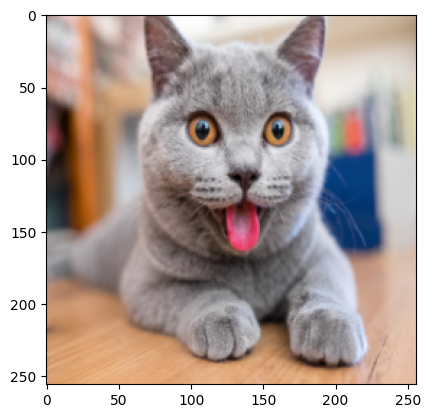

top-10 classes are: 
 [prob : class label]
0.1808 :	Egyptian Mau
0.0609 :	lynx
0.0132 :	tiger cat
0.0113 :	tabby cat
0.0097 :	Siamese cat
0.0042 :	combination lock
0.0038 :	computer mouse
0.0034 :	lens cap
0.0032 :	remote control


In [5]:
img = resize(plt.imread('cat.jpg'), (256, 256))
plt.imshow(img)
plt.show()

predict(model, img)

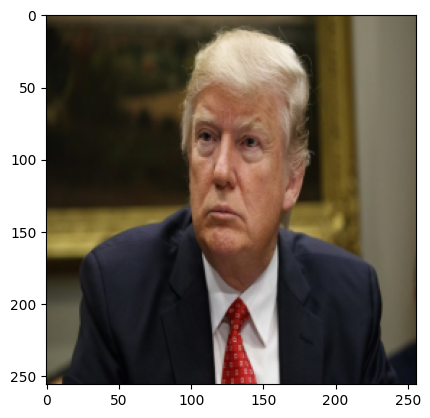

top-10 classes are: 
 [prob : class label]
0.0601 :	Windsor tie
0.0600 :	suit
0.0086 :	bow tie
0.0079 :	oboe
0.0078 :	bridegroom
0.0058 :	bassoon
0.0052 :	notebook computer
0.0051 :	saxophone
0.0050 :	cornet


In [6]:
img = resize(plt.imread('Trump.jpg'), (256, 256))
plt.imshow(img)
plt.show()

predict(model, img)

**<font color='DarkOrange'>(?) Вопрос:</font>** Как вы думате, почему для кота модель выдала верное предсказание, а в случае с Трампом - нет?

**<font color='DarkOrange'>(?) Вопрос:</font>** Каким способом можно адаптировать модель для того, чтобы она верно классифицровала Трампа?

## 2.2 HuggingFace

Hugging Face [содержит](https://huggingface.co/models) много предобученных моделей для nlp, [cv](https://github.com/huggingface/pytorch-image-models), etc.


Есть примеры [fine-tune](https://huggingface.co/docs/transformers/training) предобученных моделей.

Например, можно загрузить модель [bert](https://neerc.ifmo.ru/wiki/index.php?title=BERT_(%D1%8F%D0%B7%D1%8B%D0%BA%D0%BE%D0%B2%D0%B0%D1%8F_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C))

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# загружаем tokenizer и model
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# можно поменять слой classifier и дообучить новый Linear слой
model.classifier

Linear(in_features=768, out_features=5, bias=True)

## 2.3 Другие репо
Есть репо и библиотеки, где отдельно собраны предобученные модели для задач
1. [сегментации](https://github.com/qubvel/segmentation_models)
2. [детекции](https://github.com/ultralytics)
3. [nlp](https://sbert.net/index.html)
4. [cv](https://github.com/huggingface/pytorch-image-models?ysclid=m29fy5jrn0723234013)
5. [paperswithcode](https://paperswithcode.com/dataset/imagenet)


## 3.Пример дообучения
Попробуем дообучить модель `ResNet50` для датасета с пчелами и муравьями.

In [9]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

zipurl = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall('./data')

### 3.1 Преобразования картинок в тензоры + даталоадеры

Они соответствуют тем, которые были сделаны при обучении основной сети на датасете `ImageNet`

In [10]:
# трансформации данных

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224), # Crop a random portion of image and resize it to a given size
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456,0.406],
        [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225])])

In [11]:
# датасеты

train_dataset = datasets.ImageFolder(
          root='data/hymenoptera_data/train',
          transform=train_transforms)

val_dataset = datasets.ImageFolder(
            root='data/hymenoptera_data/val',
            transform=val_transforms)

Посмотрим на датасет

In [12]:
print(f"Размер датасета: train: {len(train_dataset)}, valid: {len(val_dataset)}")
print(f"Классы в датасете: {train_dataset.classes}")

Размер датасета: train: 244, valid: 153
Классы в датасете: ['ants', 'bees']


In [13]:
def transform_input(img):
    return torch.as_tensor(
                          img.reshape([1, 256, 256, 3]).\
                          transpose([0, 3, 1, 2]), dtype=torch.float32
                          )


def predict(model, img):
    img = transform_input(img)
    probs = torch.nn.functional.softmax(model(img), dim=-1)
    probs = probs.data.numpy()

    top_ix = probs.ravel().argsort()[-1:-2:-1].item()
    return labels[top_ix].split(',')[0]

In [14]:
# class labels
LABELS_URL = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
labels = {i: c for i, c in enumerate(requests.get(LABELS_URL).json())}

# загружаем модель
resnet50(weights="IMAGENET1K_V1")
# Initialize model
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

# Set model to eval mode
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

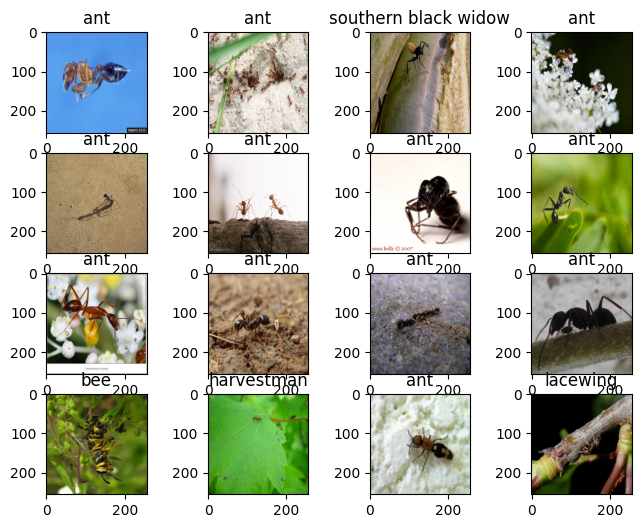

In [15]:
# визуализируем наш датасет и отрисуем предсказания моделей
n_row, n_col = 4, 4
fig, axs = plt.subplots(n_row, n_col, figsize=(8, 6))
for ax, (image_path, _) in zip(axs.flat, train_dataset.imgs[:n_row * n_col]):
  img = resize(plt.imread(image_path), (256, 256))
  class_image = predict(model, img)

  ax.set_title(class_image)
  ax.imshow(img)
  # ax.show()

Видим, что обучнная на ImageNet модель уже неплохо выдает предсказания

### **<font color='DarkOrange'>[Задание 1]</font>**
Оценить точность обученной на `ImageNet` модели.

In [16]:
cnt_true_labels = 0
cls_names = train_dataset.classes

for image_path, class_image in tqdm(train_dataset.imgs):
  img = resize(plt.imread(image_path), (256, 256))
  ## -------ваш код----------
  pred_class_image = predict(model, img)      # формируем предсказание модели
  # -------ваш код----------
  if pred_class_image == cls_names[class_image][:-1]:
    cnt_true_labels += 1

print(f'Accuracy (train): {cnt_true_labels / len(train_dataset):.2f}')

100%|██████████| 244/244 [01:19<00:00,  3.07it/s]

Accuracy (train): 0.89


In [17]:
cnt_true_labels = 0
cls_names = train_dataset.classes

for image_path, class_image in tqdm(val_dataset.imgs):
  img = resize(plt.imread(image_path), (256, 256))
  ## -------ваш код----------
  pred_class_image = predict(model, img)      # формируем предсказание модели
  # -------ваш код----------
  if pred_class_image == cls_names[class_image][:-1]:
    cnt_true_labels += 1

print(f'Accuracy (val): {cnt_true_labels / len(val_dataset):.2f}')

100%|██████████| 153/153 [00:41<00:00,  3.69it/s]

Accuracy (val): 0.83


Получаем уже неплохую точность "из коробки".

**<font color='orange'>(?) Вопрос:</font>** Как вы думате, для любых датасетов можно получить такую `accuracy` при использовании предобученных моделей?

Создаем загрузчики данных:

In [18]:
# даталоадеры
train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=4,
            shuffle=True,
            num_workers=2)

val_loader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=4,
            shuffle=True,
            num_workers=2)

### 3.2 Fine-tune модели под новый датасет

Берём обученную на 1000 классов сеть и заменяем головку на линейный модуль на нужное число выходов

In [19]:
# загружаем модель
resnet50(weights="IMAGENET1K_V1")
# Initialize model
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights) # deprecated !!!

print(model.fc)
# out:
# Linear(in_features=512, out_features=1000, bias=True)

Linear(in_features=2048, out_features=1000, bias=True)


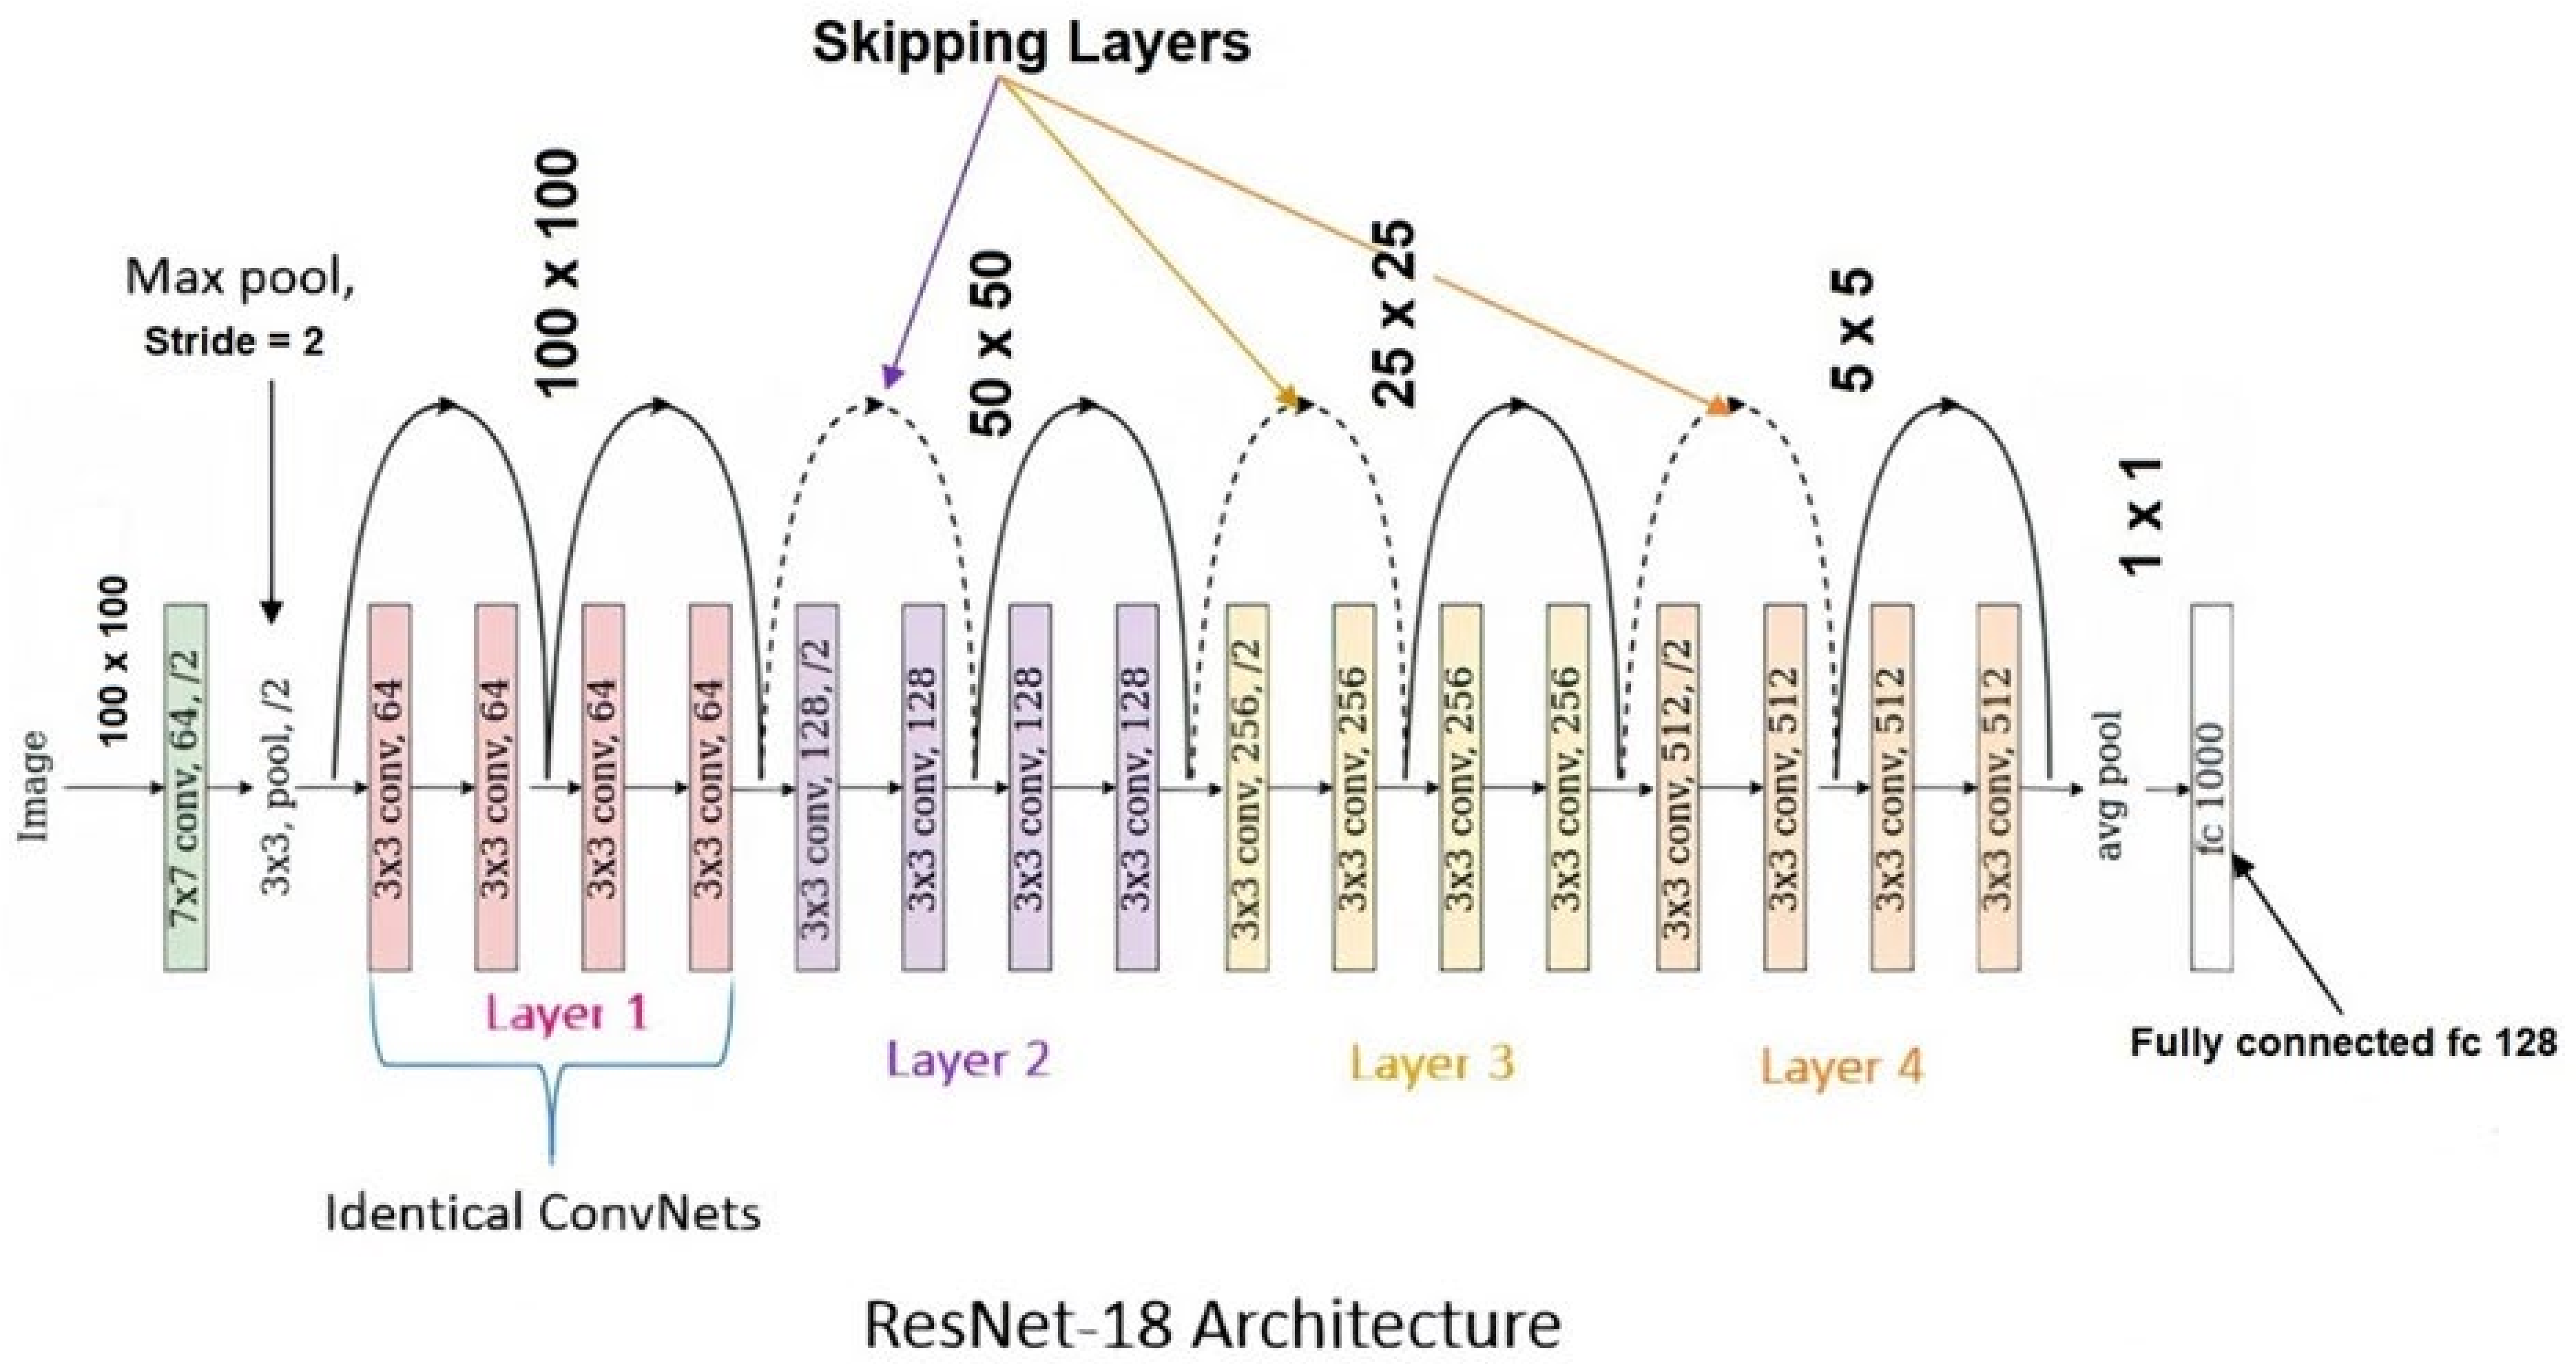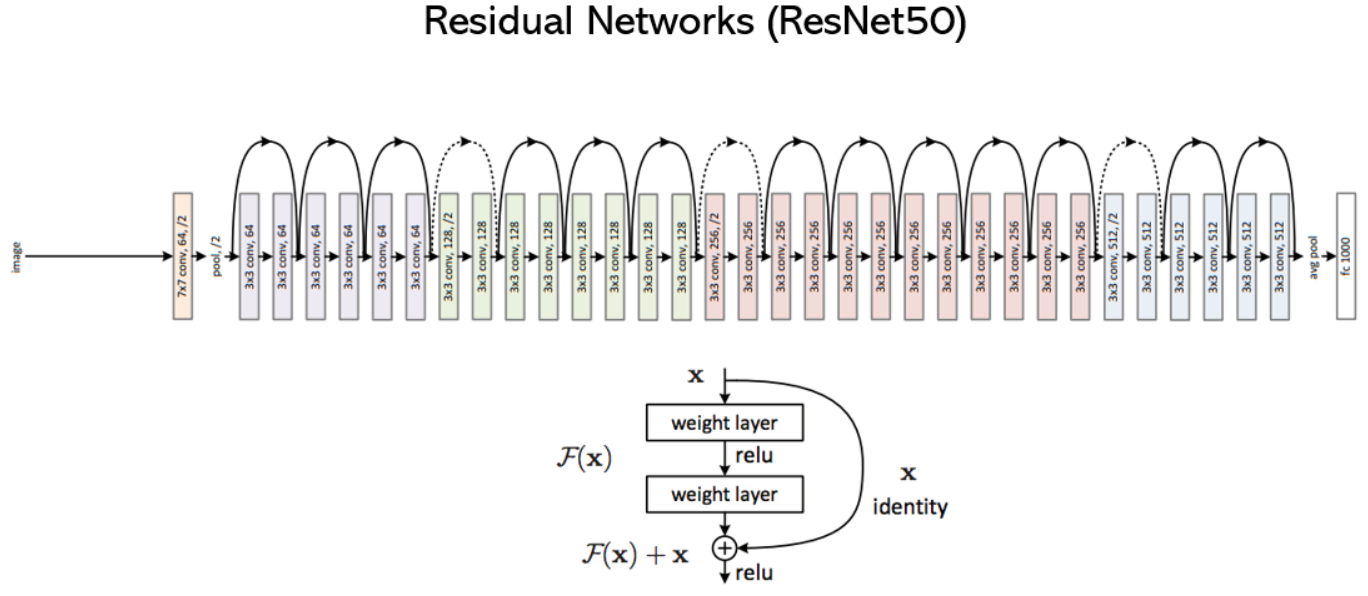

In [ ]:
# first_conv_layer_weights[i].permute(1, 2, 0)
# first_conv_layer_weights[0].shape
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

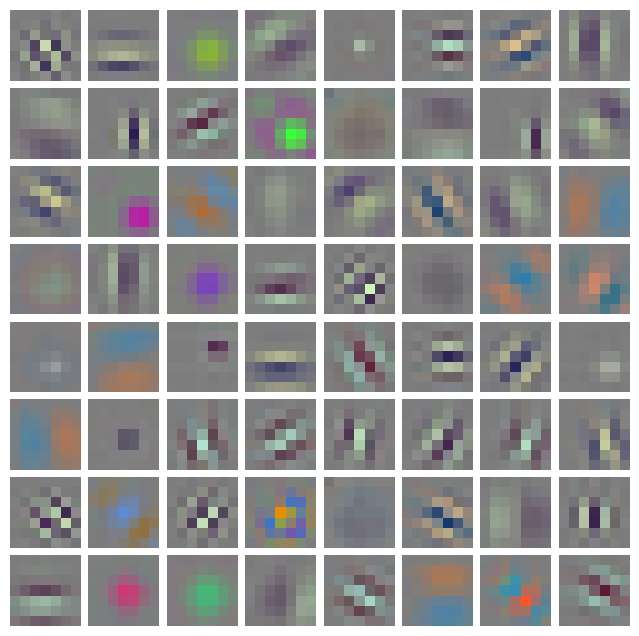

In [20]:
# ПОСМОТРИМ НА СВЁРТКИ ПЕРВОГО СЛОЯ

import matplotlib.pyplot as plt

# Получение весов первого сверточного слоя
first_conv_layer_weights = model.conv1.weight.data

# переводим на отрезок [0, 1]
normalized_weights = first_conv_layer_weights - first_conv_layer_weights.min()
normalized_weights = normalized_weights / normalized_weights.max()

# Визуализация сверток первого слоя
fig, axs = plt.subplots(8, 8, figsize=(8, 8))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i, ax in enumerate(axs.flat):
    # Конвертация весов из тензора в изображение
    ax.imshow(normalized_weights[i].permute(1, 2, 0))
    ax.axis('off')

plt.show()

Видим, что разные свертки активируются на разные формы и текстуры. Они выучивают общую информацию, которая будет полезна при классификации новых картинок.

Подготавливаем сеть к fine--tuning:
1. Замораживаем веса для всех слоев модели (устанавливаем `param.requires_grad = False`)
2. Изменяем голову сети. Нам на выходе нужно 2 класса вместо 1000 классов.

**<font color='DarkOrange'>(?) Вопрос:</font>** Некоторые слои  лучше не замораживать, а обучать (например, BatcNorm). Как вы думаете почему?

### **<font color='DarkOrange'>[Задание 2]</font>**
Оценить точность обученной на ImageNet модели.

In [23]:
# заморозка слоёв
for name, param in model.named_parameters():
    if ("bn" not in name): # BN лучше не замораживать!
    ## -------ваш код----------
      param.requires_grad = False # замораживаем часть весов
    ## -------ваш код----------

# меняем "голову" сети
## -------ваш код----------
num_ftrs =  model.fc.in_features  # определяем количество входных слоев для линейного слоя
model.fc = nn.Linear(num_ftrs, 2)  # ТУТ МЫ ДЕЛАЕМ НОВУЮ ГОЛОВУ СЕТИ
print(model.fc)
## -------ваш код----------

Linear(in_features=2048, out_features=2, bias=True)


In [24]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 3.3 Обучение только линейного слоя



### **<font color='DarkOrange'>[Задание 3]</font>**
1. Задайте функцию потерь и оптимизатор.
2. Добавьте в цикле обучения необходимые элементы

In [35]:
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # где учить

model = model.to(device) # переносим модель
## -------ваш код----------
criterion = nn.CrossEntropyLoss()  # функция ошибки

optimizer = optim.Adam(model.parameters(), lr=0.001)  # оптимизатор
## -------ваш код----------
exp_lr_scheduler = StepLR(optimizer,
                          step_size=7,
                          gamma=0.1) # через 7 шагов понижать темп

In [ ]:
# list(model.parameters())
# StepLR

In [42]:
num_epochs=40 # число эпох

for epoch in tqdm(range(num_epochs)):

    model.train()
    running_loss = 0.0
    running_corrects = 0

    # ДАЛЬШЕ ОБЫЧНЫЙ ЦИКЛ ОБУЧЕНИЯ

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        ## -------ваш код----------
        optimizer.zero_grad(set_to_none=True)
        outputs =  model(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        loss.backward()   # делаем backward
        optimizer.step()  # делаем step optimizer

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)
        ## -------ваш код----------
    exp_lr_scheduler.step()

    train_epoch_loss = running_loss / len(train_loader)
    train_epoch_acc = running_corrects / len(train_loader)

    model.eval() # <3>
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = running_corrects.double() / len(val_loader)

    print("Train: Loss: {:.4f} Acc: {:.4f}"
          " Val: Loss: {:.4f}"
          " Acc: {:.4f}".format(train_epoch_loss,
                         train_epoch_acc,
                         epoch_loss,
                         epoch_acc))
# Train: Loss: 0.0719 Acc: 0.8811 Val: Loss: 0.0401 Acc: 0.9487

  2%|▎         | 1/40 [00:04<02:52,  4.42s/it]

Train: Loss: 0.0586 Acc: 0.9139 Val: Loss: 0.0283 Acc: 0.9615


  2%|▎         | 1/40 [00:05<03:42,  5.71s/it]


KeyboardInterrupt: 

In [43]:
outputs

tensor([[-1.6117,  1.5350],
        [ 0.0290,  0.0522],
        [-0.9274,  0.9638],
        [ 0.0564, -0.3877]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [44]:
preds

tensor([1, 1, 1, 0], device='cuda:0')

In [37]:
inputs, classes = next(iter(val_loader))
out = torchvision.utils.make_grid(inputs, nrow=4)
class_names = val_dataset.classes

outputs = model(inputs.to(device))
_, preds = torch.max(outputs,1) # “winning” class

# imshow(out) #, title=[class_names[x] for x in preds])
# print([class_names[x] for x in preds])

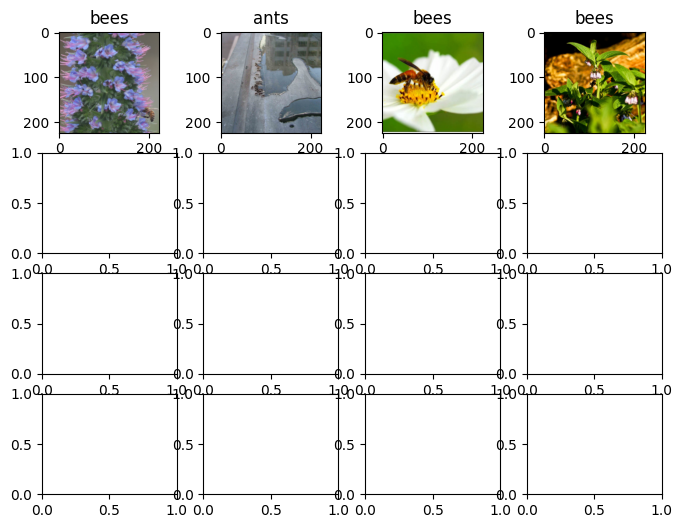

In [38]:
cls_names = train_dataset.classes
fig, axs = plt.subplots(4, 4, figsize=(8, 6))
for ax, input, cls in zip(axs.flat, inputs, classes):
  inp = input.numpy().transpose((1, 2, 0)) #  C × H × W -> H × W × C
  mean = np.array([0.485, 0.456, 0.406]) # Undo the normalization
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean # <3>
  inp = np.clip(inp, 0, 1)
  ax.set_title(cls_names[cls])
  ax.imshow(inp)

### 3.4 Дообучение всех слоев

In [45]:
# загружаем модель
resnet50(weights="IMAGENET1K_V1")
# Initialize model
weights = ResNet50_Weights.DEFAULT
# model = resnet50(weights=weights) # deprecated !!!

print(model.fc)
model.to(device)
# out:
# Linear(in_features=512, out_features=1000, bias=True)

Linear(in_features=2048, out_features=2, bias=True)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [46]:
# Разморозка всех весов
for param in model.parameters():
    param.requires_grad = True

In [47]:
num_epochs=25 # число эпох

for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    running_corrects = 0

    # ДАЛЬШЕ ОБЫЧНЫЙ ЦИКЛ ОБУЧЕНИЯ

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    exp_lr_scheduler.step()

    train_epoch_loss = running_loss / len(train_loader)
    train_epoch_acc = running_corrects / len(train_loader)

    model.eval() # <3>
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = running_corrects.double() / len(val_loader)

    print("Train: Loss: {:.4f} Acc: {:.4f}"
          " Val: Loss: {:.4f}"
          " Acc: {:.4f}".format(train_epoch_loss,
                         train_epoch_acc,
                         epoch_loss,
                         epoch_acc))

Train: Loss: 0.0587 Acc: 0.9221 Val: Loss: 0.0276 Acc: 0.9615
Train: Loss: 0.0519 Acc: 0.9344 Val: Loss: 0.0469 Acc: 0.9551
Train: Loss: 0.0579 Acc: 0.9221 Val: Loss: 0.0390 Acc: 0.9679
Train: Loss: 0.0572 Acc: 0.9262 Val: Loss: 0.0256 Acc: 0.9808
Train: Loss: 0.0602 Acc: 0.9139 Val: Loss: 0.0277 Acc: 0.9679
Train: Loss: 0.0720 Acc: 0.8975 Val: Loss: 0.0356 Acc: 0.9679
Train: Loss: 0.0540 Acc: 0.9262 Val: Loss: 0.0272 Acc: 0.9808
Train: Loss: 0.0543 Acc: 0.9180 Val: Loss: 0.0303 Acc: 0.9615
Train: Loss: 0.0649 Acc: 0.8852 Val: Loss: 0.0291 Acc: 0.9744
Train: Loss: 0.0649 Acc: 0.8934 Val: Loss: 0.0300 Acc: 0.9615
Train: Loss: 0.0542 Acc: 0.9385 Val: Loss: 0.0264 Acc: 0.9744
Train: Loss: 0.0641 Acc: 0.9180 Val: Loss: 0.0266 Acc: 0.9808
Train: Loss: 0.0612 Acc: 0.9016 Val: Loss: 0.0333 Acc: 0.9679
Train: Loss: 0.0598 Acc: 0.9221 Val: Loss: 0.0264 Acc: 0.9808
Train: Loss: 0.0681 Acc: 0.9057 Val: Loss: 0.0267 Acc: 0.9679
Train: Loss: 0.0517 Acc: 0.9344 Val: Loss: 0.0265 Acc: 0.9744
Train: L

## 4.Смотрим результаты

In [48]:
device

device(type='cuda', index=0)

In [49]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [50]:
val_loader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=16,
            shuffle=True,
            num_workers=2)

In [51]:
inputs, classes = next(iter(val_loader))
out = torchvision.utils.make_grid(inputs, nrow=4)
class_names = val_dataset.classes

outputs = model(inputs.to(device))
_, preds = torch.max(outputs,1) # “winning” class

# imshow(out) #, title=[class_names[x] for x in preds])
# print([class_names[x] for x in preds])

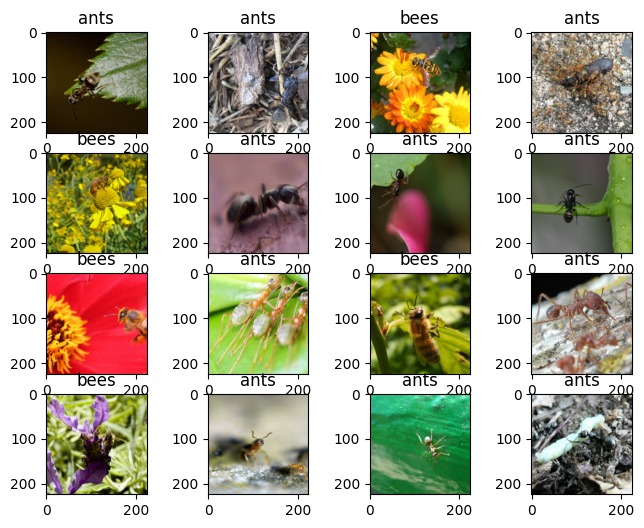

In [52]:
cls_names = train_dataset.classes
fig, axs = plt.subplots(4, 4, figsize=(8, 6))
for ax, input, cls in zip(axs.flat, inputs, classes):
  inp = input.numpy().transpose((1, 2, 0)) #  C × H × W -> H × W × C
  mean = np.array([0.485, 0.456, 0.406]) # Undo the normalization
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean # <3>
  inp = np.clip(inp, 0, 1)
  ax.set_title(cls_names[cls])
  ax.imshow(inp)

In [53]:
# сохраняем модель
torch.save(model.state_dict(), "./resnet18.pt")

## Выводы:

1. Проговорили причины применения transfer learning для задач cv и nlp.
2. Обзорно посмотрели на фреймворки с обученными моделями.
3. Провели fine-tuning предобученной модели ResNet50 для задачи классификации насекомых.

## Обратная связь

https://clck.ru/3DMKmw

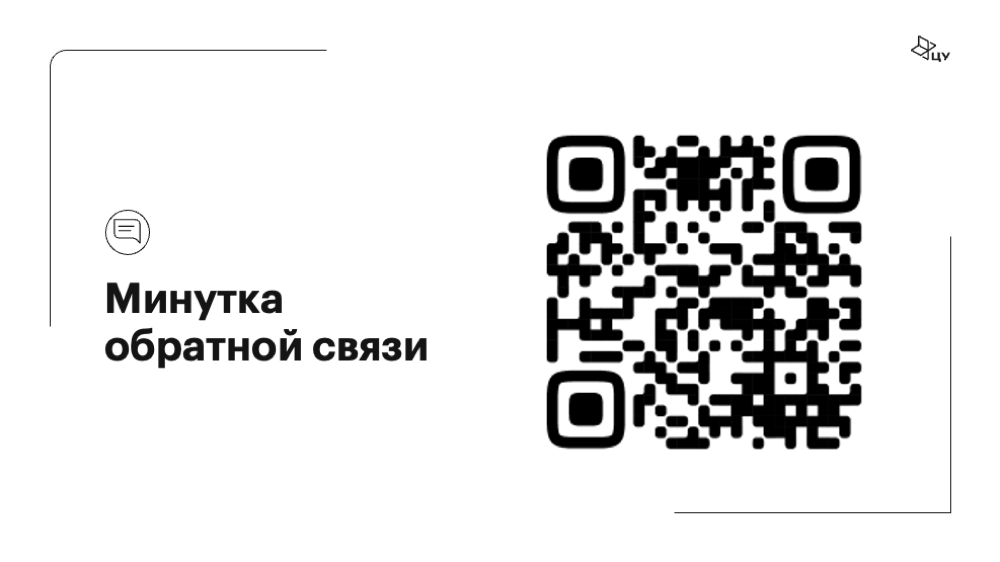